In [106]:
import pandas as pd
import numpy as np
import random
import json
from dataclasses import dataclass
import pygad
import time
random.seed(42)
import matplotlib.pyplot as plt


datasets = ["easy_dataset_1.json", "easy_dataset_2.json",
                          "medium_dataset_1.json", "medium_dataset_2.json",
                          "hard_dataset_1.json", "hard_dataset_2.json", "hard_dataset_3.json" , "hard_dataset_4.json"]

### Utils (list of function usefull to interpret or to find the right parameters)


In [9]:
def inspect_solution(solution, context, verbose=True):
    """
    Inspects the solution to identify constraint violations.
    
    Parameters:
        context (dict): A dictionary containing 'preferences', 'authorship', 'friendship', and 'capacity'.
        solution (list of list): A binary matrix where solution[i][j] = 1 if reviewer i reviews paper j.
        
    Output:
        Prints violations for each constraint if verbose=True.
        return the number of violations of soft constraints
        assert that there are no violations of hard constraints
    """

    #check authorship contraint
    authorship_violations = int(np.sum(np.multiply(solution, context["authorship"])))
    assert(authorship_violations == 0)
    if verbose:
        print(f"Authorship constraint violations: {authorship_violations}")

    #check friendship constraint
    friendship_violations = 0
    friendship = np.triu(context["friendships"])
    agents1, agents2 = np.where(friendship == 1)
    for i1, i2 in zip(agents1, agents2):
        for j in range(context["num_papers"]):
            if solution[i1][j] and solution[i2][j]:
                friendship_violations += 1

    if verbose:
        print(f"Friendship constraint violations: {friendship_violations}")


    #check capacity constraint for paper
    capacity_violations_paper = 0
    capacity_interval = (context["min_reviews_per_paper"], context["max_reviews_per_paper"])
    reviews_per_paper = np.sum(solution, axis=0)
    for i in reviews_per_paper:
        if i < capacity_interval[0] or i > capacity_interval[1]:
            capacity_violations_paper += 1
    assert(capacity_violations_paper == 0)
    if verbose: 
        print(f"Capacity constraint violations for papers: {capacity_violations_paper}")

    #check capacity constraint for reviewer
    capacity_violations_reviewer = 0
    max_reviews_per_reviewer = context["reviewer_capacity"]
    reviews_per_reviewer = np.sum(solution, axis=1)
    for i in reviews_per_reviewer:
        if i < max_reviews_per_reviewer:
            capacity_violations_reviewer += 1
    if verbose:
        print(f"Capacity constraint violations for reviewers: {capacity_violations_reviewer}")

    #return the number of violations of soft constraints
    return friendship_violations + capacity_violations_reviewer

# First Step : convert the data into the right datatype

## Fitness Function: Evaluating Reviewer Assignments

The fitness function is a key component of our genetic algorithm. Its purpose is to quantify the satisfaction of reviewers while also accounting for constraints by penalizing violations. Then maximizing it optimize reviewer preferences but also incorporates important constraints.

---
The fitness function relies on several key matrices and elements (given by the problem): 

In the following, 
   - $ n $ is the number of reviewers.
   - $ m $ is the number of papers.

 **Preference Matrix $ P $**
   - **Purpose**: This matrix captures the satisfaction each reviewer has for each paper.
   - **Description**: Each element $ P[i, j] $ represents how much reviewer $ i $ prefers reviewing paper $ j $. 

$$
P \in \mathbb{N}^{n \times m}, \quad P[i, j] \text{ is the preference of reviewer } i \text{ for paper } j
$$


 **Authorship Matrix $ A_{\text{auth}} $**
   - **Purpose**: This matrix indicates which reviewer is the author of which paper.
   - **Description**: Each element $ A_{\text{auth}}[i, j] $ is $ 1 $ if reviewer $ i $ is the author of paper $ j $, and $ 0 $ if they are not. This is important because we want to avoid authors reviewing their own papers.
$$
A_{\text{auth}} \in \{0, 1\}^{n \times m}, \quad A_{\text{auth}}[i, j] = 1 \text{ if reviewer } i \text{ authored paper } j
$$


 **Friendship Matrix $ F $**
   - **Purpose**: This matrix represents the friendship relationships between reviewers. Friendships are important because two friends should not review the same paper to avoid conflicts of interest.
   - **Description**: Each element $ F[i, j] = 1 $ if reviewers $ i $ and $ j $ are friends, and $ 0 $ if they are not.

$$
F \in \{0, 1\}^{n \times n}, \quad F[i, j] = 1 \text{ if reviewer } i \text{ and reviewer } j \text{ are friends}
$$

**Additional Constraints**
#TODO explain here the others stuff like the max number of paper etc.. 

---
### Structure (datatype) of one solution

To model a solution, we represent each solution as a matrix $A$ ($n \times p$) where each element indicates the assignment of a reviewer to a paper.

$$
A[i, j] = 1 \quad \text{if reviewer } i \text{ is assigned to paper } j, \quad A[i, j] = 0 \quad \text{otherwise.}
$$
___

### The fitness function
**1. Satisfaction Score**

We construct our fitness function using a satisfaction matrix, defined as follows. 
The satisfaction score is computed by:

$$
S = \sum_{i=1}^n \sum_{j=1}^m A[i, j] \cdot P[i, j]
$$

This allows us to capture the satisfaction of reviewers without considering any constraints. Then, step by step, we refine this matrix to incorporate the various constraints. 


**2. Authorship Constraint**

Reviewers cannot review papers they authored. This is penalized using the authorship matrix $ A_{auth} $. The modified satisfaction matrix incorporates this constraint:

$$
S' = S \cdot (1 - \text{author\_weight} \cdot A_{auth})
$$

Here, `author_weight` determines the penalty applied to assignments violating this constraint.



**3. Friendship Constraint**

If two reviewers who are friends review the same paper, their satisfaction scores are reduced. 
For every pair of friends $ (i, k) $:

$$
S''[i, j] = S'[i, j] \cdot \text{friendship\_weight} \quad \text{if} \quad S'[i, j] > 0 \text{ and } S'[k, j] > 0
$$

Here, `friendship_weight` reduces the satisfaction score for shared papers between friends.



 **4. Final Fitness Score**

Finally, to obtain a scalar output from our fitness function, we compute the sum of the adjusted satisfaction matrix S′′
$$
\text{Fitness} = \sum_{i=1}^n \sum_{j=1}^m S''[i, j]
$$


In [ ]:
class GeneticAlgorithm:
    def __init__(self, file_path:str):
        self.context = self.import_data(file_path)
        self.ga_instance = None
        self.datasets = ["easy_dataset_1.json", "easy_dataset_2.json",
                          "medium_dataset_1.json", "medium_dataset_2.json",
                          "hard_dataset_1.json", "hard_dataset_2.json", "hard_dataset_3.json" , "hard_dataset_4.json"]
        
        self.w_friends = 1
        self.w_reviewer_capacity = 1 
    

    def import_data(self, file:str): # json file 
        with open(file) as f:
            data = json.load(f)

            # convert to numpy array
            data["preferences"] = np.array(data["preferences"])
            data["authorship"] = np.array(data["authorship"])
            data["friendships"] = np.array(data["friendships"])

        return data


######################## FITNESS FUNCTIONS ########################
    def fitness(self, agent: np.array, constraints_weight = 0.1, author_weight=0.9, friendship_weight=0.5):
        """ 
        Returns a score corresponding to the satisfaction the agent obtains with respect to the constraints
        we want him to follow.
        """
        agent = agent.reshape(self.context["preferences"].shape)
        n = self.context["num_reviewers"]
        m = self.context["num_papers"]

        min_reviewers = self.context["min_reviews_per_paper"]
        max_reviewers = self.context["max_reviews_per_paper"]

        max_papers = self.context["reviewer_capacity"]

        constraint_penalty = 1
        # Apply max papers per reviewer constraint
        for reviewer in agent:
            nb_reviewed_papers = len(reviewer[reviewer != 0])
            if max_papers < nb_reviewed_papers :
                constraint_penalty = constraint_penalty * (nb_reviewed_papers - max_papers) * constraints_weight

        # Satisfaction matrix: the pleasure each reviewer takes by reviewing it's attributed papers
        satisfaction = agent * self.context["preferences"]

        # Add friendship penalty
        friendship = np.triu(self.context["friendships"])    # only need upper triangular part because matrix is symmetric
        agents1, agents2 = np.where(friendship == 1)

        # Iterate over every pair of friends
        for i1, i2 in zip(agents1, agents2):
            # And then over all the papers they can review
            for j in range(m):
                if satisfaction[i1, j] and satisfaction[i2, j]: # Case where 2 friends review the same paper
                    satisfaction[i1, j] = satisfaction[i1, j]*friendship_weight
                    satisfaction[i2, j] = satisfaction[i2, j]*friendship_weight

        score = np.sum(satisfaction) * constraint_penalty

        return score
    
    def fitness2(self, agent: np.array):
        """ 
        Returns a score corresponding to the satisfaction the agent obtains with respect to the constraints
        we want him to follow.
        """
        agent = agent.reshape(self.context["preferences"].shape)
        n = self.context["num_reviewers"]
        m = self.context["num_papers"]

        max_papers = self.context["reviewer_capacity"]

        #sastisfaction matrix
        satisfaction = np.sum(agent * self.context["preferences"])
        satisfaction = satisfaction / np.sum(self.context["preferences"])

        #check friendship constraint
        friendship_violations = 0
        friendship = np.triu(self.context["friendships"])
        agents1, agents2 = np.where(friendship == 1)
        for i1, i2 in zip(agents1, agents2):
            for j in range(self.context["num_papers"]):
                if agent[i1][j] and agent[i2][j]:
                    friendship_violations += 1

        #normalize 
        friendship_violations = friendship_violations / np.sum(self.context["friendships"])


        #check capacity constraint for reviewer
        capacity_violations_reviewer = 0
        max_reviews_per_reviewer = self.context["reviewer_capacity"]
        reviews_per_reviewer = np.sum(agent, axis=1)
        for i in reviews_per_reviewer:
            if i < max_reviews_per_reviewer:
                capacity_violations_reviewer += 1
        
        #normalize
        capacity_violations_reviewer = capacity_violations_reviewer / self.context["num_reviewers"]

        return 10 * satisfaction - self.w_reviewer_capacity*capacity_violations_reviewer - self.w_friends*friendship_violations

    def fitness_wrapper(self, ga_instance, solution, solution_idx):
        return self.fitness2(solution) # make sure to pass the context and to have define fitness before
    

    
    

######################## CROSSOVER FUNCTIONS ########################
    def crossover_1(self, parents, offspring_size, ga_instance):
        """
        Build new agents by cutting each parent in half (verticaly) and pasting them together. 

        Parameters:

        parents (np.array) : Array of parents we want to mate.
        offspring_size (tuple) : Number of offsprings we want to generate and their respective length.
        ga_instance (pygad.GA) : Refere to the genetic algorithme we are executing. Can be used to 
        access the parameters of the experience.

        Return:

        new_agents (np.array) : Array of new agents according to the offspring_size parameter.
        """
        new_agents = np.empty(offspring_size)
        preferences = self.context["preferences"]
        width = np.shape(preferences)[1]

        for k in range(offspring_size[0]):
            # Choose the parents randomly
            i = random.randint(0, np.shape(parents)[0]-1)
            j = random.choice([l for l in range(0,np.shape(parents)[0]) if l != i])

            # Reshape them into array dimensions according to the preference matrix
            daddy = parents[i].reshape(np.shape(preferences))
            mommy = parents[j].reshape(np.shape(preferences))

            # Build the child by pasting the left part of daddy and the right part of mommy together
            child = np.zeros_like(preferences)
            child[:, :width//2] = daddy[:, :width//2]
            child[:, width//2:] = mommy[:, width//2:]

            assert len(child.flatten() == offspring_size[1])

            # Flatten the child to make its dimension feat with the expected one
            new_agents[k] = child.flatten()

        return new_agents


    def crossover_2(self, parents, offspring_size, ga_instance):
        """
        Build new agents by randomly picking its columns among the ones of each parent. 

        Parameters:

        parents (np.array) : Array of parents we want to mate.
        offspring_size (tuple) : Number of offsprings we want to generate and their length.
        ga_instance (pygad.GA) : Refere to the genetic algorithme we are executing. Can be used to 
        access the parameters of the experience.

        Return:
        
        new_agents (np.array) : Array of new agents according to the offspring_size parameter.
        """
        real_dim = np.shape(self.context["preferences"])
        new_agents = np.empty(offspring_size)

        for k in range(offspring_size[0]):
            # Choose the parents randomly
            i = random.randint(0, np.shape(parents)[0]-1)
            j = random.choice([l for l in range(0,np.shape(parents)[0]) if l != i])

            # Get genitors and create futur child
            genitors = (parents[i].reshape(real_dim), parents[j].reshape(real_dim))
            child = np.zeros(real_dim)

            # Chose the columns randomly and fill the child with
            for l in range(real_dim[1]):
                child[:, l:l+1] = genitors[random.randint(0,1)][:, l:l+1]

            assert len(child.flatten() == offspring_size[1])
            new_agents[k] = child.flatten()

        return new_agents

    def crossover_3(self, parents, offspring_size, ga_instance):
        """
        Apply the AND operator between the parents columns.
        Fill the column more if needed, in order to keep respecting the constraints.

        Parameters:

        parents (np.array) : Array of parents we want to mate.
        offspring_size (tuple) : Number of offsprings we want to generate and their length.
        ga_instance (pygad.GA) : Refere to the genetic algorithme we are executing. Can be used to 
        access the parameters of the experience.

        Return:
        
        new_agents (np.array) : Array of new agents according to the offspring_size parameter.
        """
        real_dim = np.shape(self.context["preferences"])
        new_agents = np.empty(offspring_size)

        for k in range(offspring_size[0]):
            # Choose the parents randomly
            i = random.randint(0, np.shape(parents)[0]-1)
            j = random.choice([l for l in range(0,np.shape(parents)[0]) if l != i])

            # Get genitors and create futur child
            daddy = parents[i].reshape(real_dim)
            mommy = parents[j].reshape(real_dim)
            child = np.zeros(real_dim)

            # AND operator between every couple of columns 
            for l in range(real_dim[1]):
                merged_col = daddy[:, l:l+1] & mommy[:, l:l+1]
                authors = self.context["authorship"][:, l:l+1]

                # Insure the min reviewers per paper and authorship are respected
                while np.sum(merged_col) < self.context["min_reviews_per_paper"]:
                    available_cells = (merged_col == 0) & (authors == 0)
                    available_indices = [i for i in range(np.shape(merged_col)[0]) if available_cells[i]]
                    
                    # Case where the constraints are incompatible
                    if len(available_indices) != 0:
                        print(f"You have no cell left where to put an other reviewer for the paper {l}.")
                        break
                    
                    merged_col[random.choice(available_indices)][0] = 1
            
                child[:, l:l+1] = merged_col

            assert len(child.flatten() == offspring_size[1])
            new_agents[k] = child.flatten()

        return new_agents


    def crossover_4(self, parents, offspring_size, ga_instance):
        """
        Apply the OR operator between the parents columns.
        Empty the column more if needed, in order to keep respecting the constraints.

        Parameters:

        parents (np.array) : Array of parents we want to mate.
        offspring_size (tuple) : Number of offsprings we want to generate and their length.
        ga_instance (pygad.GA) : Refere to the genetic algorithme we are executing. Can be used to 
        access the parameters of the experience.

        Return:
        
        new_agents (np.array) : Array of new agents according to the offspring_size parameter.
        """
        real_dim = np.shape(self.context["preferences"])
        new_agents = np.empty(offspring_size)

        for k in range(offspring_size[0]):
            # Choose the parents randomly
            i = random.randint(0, np.shape(parents)[0]-1)
            j = random.choice([l for l in range(0,np.shape(parents)[0]) if l != i])

            # Get genitors and create futur child
            daddy = parents[i].reshape(real_dim)
            mommy = parents[j].reshape(real_dim)
            child = np.zeros(real_dim)

            # OR operator between every couple of columns 
            for l in range(real_dim[1]):
                merged_col = daddy[:, l:l+1] | mommy[:, l:l+1]
                authors = self.context["authorship"][:, l:l+1]

                # Insure the max reviewers per paper and authorship are respected
                while self.context["max_reviews_per_paper"] < np.sum(merged_col):
                    available_cells = (merged_col == 1) & (authors == 0)
                    available_indices = [i for i in range(np.shape(merged_col)[0]) if available_cells[i]]
                    
                    # Case where the constraints are incompatible
                    if len(available_indices) != 0:
                        print(f"You have no cell left where to put an other reviewer for the paper {l}.")
                        break
                    
                    merged_col[random.choice(available_indices)][0] = 0
            
                child[:, l:l+1] = merged_col

            assert len(child.flatten() == offspring_size[1])
            new_agents[k] = child.flatten()

        return new_agents


######################## MUTATION FUNCTIONS ########################
    #----Custom mutation/crossover functions----

    def mutation(self, offspring, ga_instance): 
        """ swap a paper from a reviewer to another making sure that the
            constraints are respected or add or remove a paper from a reviewer"""
        
        # choose a random solution
        r = random.randint(0, offspring.shape[0]-1)
        solution = offspring[r]
        solution = solution.reshape(self.context["preferences"].shape)
        n, m = self.context["preferences"].shape

        # choose a random paper
        paper = random.randint(0, m-1)
        # choose randomly between adding removing or swapping a paper

        mutation_flag = False
        option = random.choice(["add", "remove", "swap"])

        if option == "add":
            if np.sum(solution[:, paper]) < self.context["max_reviews_per_paper"]:
                # list of free reviewers that can review the paper
                free_reviewers = np.where(solution[:, paper] == 0)[0]
                # check authorship constraint
                free_reviewers = [r for r in free_reviewers if self.context["authorship"][r, paper] == 0]

                if len(free_reviewers) > 0:
                    # choose a random reviewer
                    reviewer = random.choice(free_reviewers)
                    solution[reviewer, paper] = 1
                    mutation_flag = True
        
        if option == "remove":
            if np.sum(solution[:, paper]) > self.context["min_reviews_per_paper"]:
                # list of reviewers that we can remove the paper
                reviewers = np.where(solution[:, paper] == 1)[0]
                if len(reviewers) > 0:
                    # choose a random reviewer
                    reviewer = random.choice(reviewers)
                    solution[reviewer, paper] = 0
                    mutation_flag = True


        if option == "swap" or not mutation_flag: 
            # choose 1 reviewer that is reviewing the paper
            reviewers = np.where(solution[:, paper] == 1)[0]
            free_reviewers = np.where(solution[:, paper] == 0)[0]
            #check authorship constraint
            free_reviewers = [r for r in free_reviewers if self.context["authorship"][r, paper] == 0]
            
            if len(reviewers) > 0 and len(free_reviewers) > 0:
                reviewer1 = random.choice(reviewers)
                reviewer2 = random.choice(free_reviewers)
                solution[reviewer1, paper] = 0
                solution[reviewer2, paper] = 1
                mutation_flag = True

        if not mutation_flag: 
            print("No mutation was done") 

        offspring[r] = solution.flatten()
        return offspring


######################## RUNNING FUNCTIONS ########################
    def run(self, num_generations=1000, num_parents_mating=5, sol_per_pop=20,
            parent_selection_type="tournament", mutation_type="random", mutation_percent_genes=10, crossover_type="single_point"):
        
        pop = self.generate_initial_population(sol_per_pop, self.context["num_papers"]*self.context["num_reviewers"])
        #print(pop)
        self.ga_instance =  pygad.GA(num_generations=num_generations,
                                        initial_population=pop,
                                        num_parents_mating=num_parents_mating, 
                                        fitness_func=self.fitness_wrapper,
                                        sol_per_pop=sol_per_pop,
                                        num_genes=self.context["num_papers"]*self.context["num_reviewers"],
                                        gene_space=[0,1],
                                        parent_selection_type=parent_selection_type,
                                        mutation_percent_genes= mutation_percent_genes,
                                        mutation_type=self.mutation,
                                        crossover_type=self.crossover_1
                                        )
        self.ga_instance.run()
        solution, solution_fitness, _ = self.ga_instance.best_solution()

        return solution.reshape(self.context["preferences"].shape), solution_fitness
        

    # Fonction pour générer un individu valide
    def generate_valid_individual(self):
        individual = np.zeros_like(self.context["preferences"])
        _, m = np.shape(self.context["preferences"])

        for paper in range(m): 
            possible_reviewers = np.where(self.context["authorship"][:, paper] == 0)[0]
            assert len(possible_reviewers) >= self.context["min_reviews_per_paper"], "Not enough reviewers to review the paper"
            num_reviewers = random.randint(self.context["min_reviews_per_paper"], min(self.context["max_reviews_per_paper"], len(possible_reviewers)))
            
            reviewers = random.sample(list(possible_reviewers), num_reviewers)
            for reviewer in reviewers:
                individual[reviewer, paper] = 1
        
        return individual.flatten()

            

    # Fonction pour générer une population valide
    def generate_initial_population(self, pop_size, gene_length):
        population = np.array([self.generate_valid_individual() for _ in range(pop_size)])
        return population


In [111]:
modele = GeneticAlgorithm(f"datasets/{datasets[3]}")
modele.w_friends = 100000
modele.w_reviewer_capacity = 100000
solution , fitness = modele.run()
print(fitness)
inspect_solution(solution, modele.context)
# for _ in range(10000):
# a = modele.generate_valid_individual().reshape(modele.context["preferences"].shape)
# b = modele.generate_valid_individual().reshape(modele.context["preferences"].shape)
# c = modele.crossover_3([a,b], (1, modele.context["preferences"].shape[0]*modele.context["preferences"].shape[1]), None).reshape(modele.context["preferences"].shape)
# inspect_solution(a, modele.context) 



-12495.23076923077
Authorship constraint violations: 0
Friendship constraint violations: 0
Capacity constraint violations for papers: 0
Capacity constraint violations for reviewers: 1


1

In [73]:
modele = GeneticAlgorithm("datasets/easy_dataset_1.json")

for _ in range(10000):
    agent1 = modele.generate_valid_individual()
    agent2 = modele.generate_valid_individual()

    child = modele.crossover_1([agent1, agent2], (1, 25), None)
    mutant = modele.mutation(None, child)
    inspect_solution(agent1.reshape(5,5), modele.context)

AttributeError: 'NoneType' object has no attribute 'shape'

# finding the right parameters for the fitness function 
Our fitness function is designed to account for reviewer satisfaction while incorporating two soft constraints: the friendship constraint and the reviewer capacity constraint. These constraints can be violated but should be minimized as much as possible.

To achieve this, we introduced two parameters that control the penalty applied to each constraint.

In this section, we will analyze which combinations of these parameters yield the best results

In [78]:
modele = GeneticAlgorithm(f"datasets/{datasets[7]}")
modele.w_friends = 3
modele.w_reviewer_capacity = 3
solution , fitness = modele.run()
print(fitness)
inspect_solution(solution, modele.context)

0.6345447365586896
Authorship constraint violations: 0
Friendship constraint violations: 55
Capacity constraint violations for papers: 0
Capacity constraint violations for reviewers: 9


64

## Tuning of hyperparameters of the GA 

In [81]:
#Utils
def hyperparameter_tuning(ga):
    """We will run the genetic algorithm with different hyperparameters and return the best ones."""


    # Define the hyperparameters we want to tune
    param_ranges = {
    "num_generations": [50, 100, 500, 1000],
    "num_parents_mating": [5, 10, 20],
    "sol_per_pop": [20, 30, 40, 50],
    "parent_selection_type": ["tournament", "random"],
    "mutation_percent_genes": [5, 10, 20],
    "crossover_type": ["mutation1", "mutation2", "mutation3", "mutation4"] }

    param_scores = dict() # should be exactly the same shape as param_ranges

    # varying num generations
    for num_generations in param_ranges["num_generations"]:
        _, score = ga.run(num_generations=num_generations)

        if "num_generations" not in param_scores:
            param_scores["num_generations"] = {num_generations: score}
        else:
            param_scores["num_generations"][num_generations] = score
    print("Done with num_generations")

    # varying num parents mating
    for num_parents_mating in param_ranges["num_parents_mating"]:
        _, score = ga.run(num_parents_mating=num_parents_mating)
        if "num_parents_mating" not in param_scores:
            param_scores["num_parents_mating"] = {num_parents_mating: score}
        else:
            param_scores["num_parents_mating"][num_parents_mating] = score
    print("Done with num_parents_mating")



    # varying sol per pop
    for sol_per_pop in param_ranges["sol_per_pop"]:
        _, score = ga.run(sol_per_pop=sol_per_pop)
        if "sol_per_pop" not in param_scores:
            param_scores["sol_per_pop"] = {sol_per_pop: score}
        else:
            param_scores["sol_per_pop"][sol_per_pop] = score
    print("Done with sol_per_pop")
    
    # varying parent selection type
    for parent_selection_type in param_ranges["parent_selection_type"]:
        _, score = ga.run(parent_selection_type=parent_selection_type)

        if "parent_selection_type" not in param_scores:
            param_scores["parent_selection_type"] = {parent_selection_type: score}
        else:
            param_scores["parent_selection_type"][parent_selection_type] = score
    print("Done with parent_selection_type")
    

    # varying mutation percent genes
    for mutation_percent_genes in param_ranges["mutation_percent_genes"]:
        _, score = ga.run(mutation_percent_genes=mutation_percent_genes)
        if "mutation_percent_genes" not in param_scores:
            param_scores["mutation_percent_genes"] = {mutation_percent_genes: score}
        else:
            param_scores["mutation_percent_genes"][mutation_percent_genes] = score
    print("Done with mutation_percent_genes")

    # varying crossover type
    for crossover_type in param_ranges["crossover_type"]:
        if crossover_type == "mutation1":
            _, score = ga.run(crossover_type=ga.crossover_1)
        elif crossover_type == "mutation2":
            _, score = ga.run(crossover_type=ga.crossover_2)
        elif crossover_type == "mutation3":
            _, score = ga.run(crossover_type=ga.crossover_3)
        elif crossover_type == "mutation4":
            _, score = ga.run(crossover_type=ga.crossover_4)

        if "crossover_type" not in param_scores:
            param_scores["crossover_type"] = {crossover_type: score}
        else:
            param_scores["crossover_type"][crossover_type] = score
    print("Done with crossover_type")


    return param_scores

In [100]:
scores_according_to_hyperparameters = hyperparameter_tuning(modele)
scores_according_to_hyperparameters

/Users/luc/miniconda3/envs/intSyst/lib/python3.12/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Done with num_generations
Done with num_parents_mating
Done with sol_per_pop
Done with parent_selection_type
Done with mutation_percent_genes
Done with crossover_type


{'num_generations': {50: -1.7060322854715375,
  100: -0.9215240465734083,
  500: 0.2685589606742689,
  1000: 1.2607927371649892},
 'num_parents_mating': {5: 1.0155404246492836,
  10: 1.2150549858197615,
  20: 1.3198112492570835},
 'sol_per_pop': {20: 1.17996537708266,
  30: 0.9631991894727183,
  40: 1.1948057646359607,
  50: 0.9074056346005802},
 'parent_selection_type': {'tournament': 0.9878101802545665,
  'random': 0.04844615697583987},
 'mutation_percent_genes': {5: 0.991717224901376,
  10: 1.1703642985069862,
  20: 0.9705904643379957},
 'crossover_type': {'mutation1': 1.2972465207558006,
  'mutation2': 0.9658058803116063,
  'mutation3': 1.4656104283588816,
  'mutation4': 1.3489794615897022}}

### Number of generations analysis

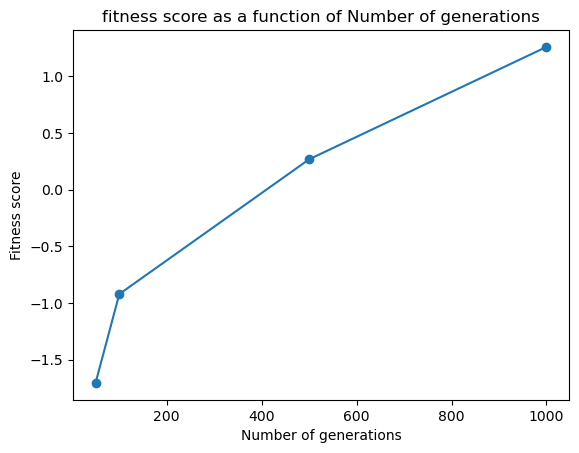

In [123]:
# plot the results
def plot_scores_as_curve(scores_according_to_hyperparameters, key:str, xlabel:str):
    score = scores_according_to_hyperparameters[key]
    x = list(score.keys())
    y = list(score.values())
    assert len(x) == len(y)
    plt.plot(x, y, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel("Fitness score")
    plt.title(f"fitness score as a function of {xlabel}")
    plt.show()

plot_scores_as_curve(scores_according_to_hyperparameters, "num_generations", "Number of generations")


### Number of parents mating analysis

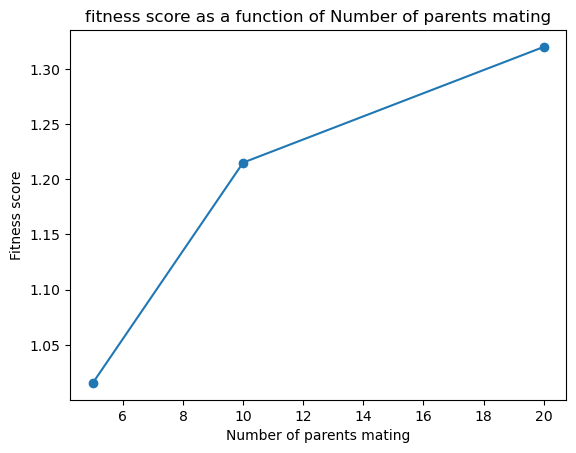

In [119]:
plot_scores_as_curve(scores_according_to_hyperparameters, "num_parents_mating", "Number of parents mating")

### Size of the population per generation

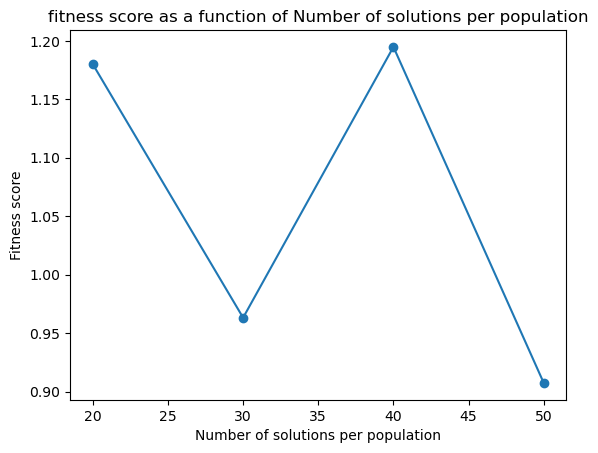

In [120]:
plot_scores_as_curve(scores_according_to_hyperparameters, "sol_per_pop", "Number of solutions per population")

### Mutation rate

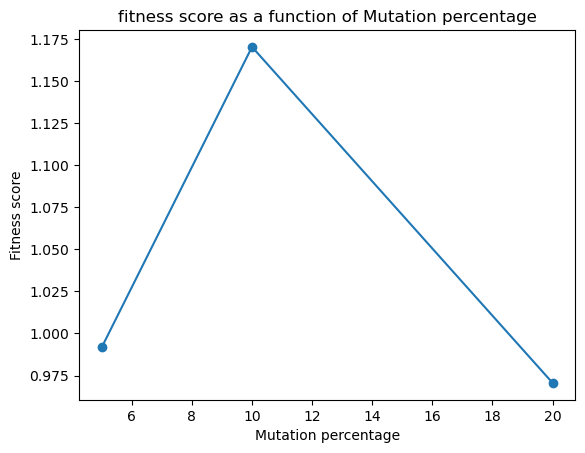

In [121]:
plot_scores_as_curve(scores_according_to_hyperparameters, "mutation_percent_genes", "Mutation percentage")

### Parent selection method

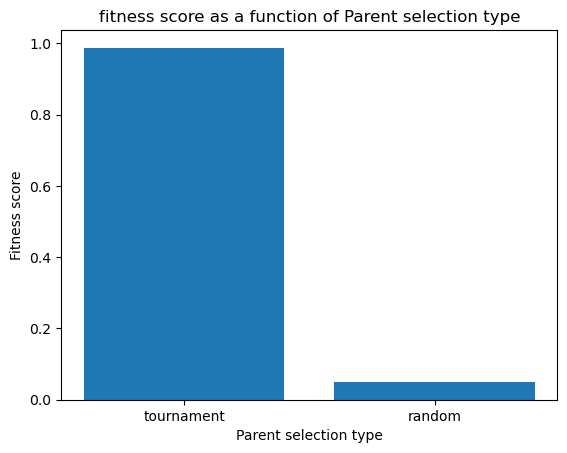

In [125]:
def plot_scores_as_bar(scores_according_to_hyperparameters, key:str, xlabel:str):
    score = scores_according_to_hyperparameters[key]
    x = list(score.keys())
    y = list(score.values())
    assert len(x) == len(y)
    plt.bar(x, y)
    plt.xlabel(xlabel)
    plt.ylabel("Fitness score")
    plt.title(f"fitness score as a function of {xlabel}")
    plt.show()

plot_scores_as_bar(scores_according_to_hyperparameters, "parent_selection_type", "Parent selection type")

### Crossover method 

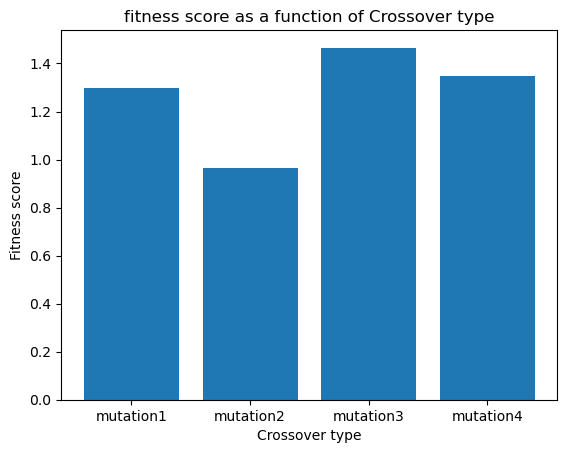

In [126]:
plot_scores_as_bar(scores_according_to_hyperparameters, "crossover_type", "Crossover type")

# Results and execution time for each problem (datatets )